Installation of Environment Setup

In [ ]:
# Install TensorFlow 2.18.0 and segmentation-models 1.0.1
!pip install --upgrade tensorflow==2.18.0 segmentation-models==1.0.1

# Uninstall and reinstall protobuf to force version 3.20.3
!pip uninstall -y protobuf
!pip install protobuf==3.20.3

# Install kagglehub (if not already installed)
!pip install kagglehub

# Set environment variables BEFORE importing other packages
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
os.environ["PROTOCOL_BUFFERS_PYTHON_IMPLEMENTATION"] = "python"

# Import necessary libraries and mount Google Drive (if needed)
import tensorflow as tf
print("TensorFlow version:", tf.__version__)
import tensorflow.keras as keras
print("tf.keras is available.")

import segmentation_models as sm
import glob
import cv2
import nibabel as nib
import kagglehub
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 4.9 MB/s eta 0:00:00
Found existing installation: protobuf 4.25.6
Uninstalling protobuf-4.25.6:
  Successfully uninstalled protobuf-4.25.6
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 11.4 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.16.1 requires protobuf<6.0.0dev,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.


TensorFlow version: 2.18.0
tf.keras is available.
Segmentation Models: using `tf.keras` framework.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Download Dataset From Kaggle

In [ ]:
# Download the BraTS2020 dataset (training+validation) from Kaggle
DATASET_NAME = "awsaf49/brats20-dataset-training-validation"
dataset_path = kagglehub.dataset_download(DATASET_NAME)
print("Dataset downloaded to:", dataset_path)

# Inspect the downloaded folder structure
!ls -lh "{dataset_path}"

# Copy the extracted TrainingData folder (which contains the patient subdirectories)
!mkdir -p /content/brats_data
!cp -r "{dataset_path}/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData" /content/brats_data/

# Set the training data directory to the copied folder
BRATS_DATA_DIR = "/content/brats_data/MICCAI_BraTS2020_TrainingData"
!ls -lh "{BRATS_DATA_DIR}"

100%|██████████| 4.16G/4.16G [03:06<00:00, 23.9MB/s]

Extracting files...


Dataset downloaded to: /root/.cache/kagglehub/datasets/awsaf49/brats20-dataset-training-validation/versions/1
total 8.0K
drwxr-xr-x 3 root root 4.0K Mar 14 05:46 BraTS2020_TrainingData
drwxr-xr-x 3 root root 4.0K Mar 14 05:50 BraTS2020_ValidationData
total 1.5M
drwxr-xr-x 2 root root 4.0K Mar 14 05:51 BraTS20_Training_001
drwxr-xr-x 2 root root 4.0K Mar 14 05:51 BraTS20_Training_002
drwxr-xr-x 2 root root 4.0K Mar 14 05:51 BraTS20_Training_003
drwxr-xr-x 2 root root 4.0K Mar 14 05:51 BraTS20_Training_004
drwxr-xr-x 2 root root 4.0K Mar 14 05:51 BraTS20_Training_005
drwxr-xr-x 2 root root 4.0K Mar 14 05:51 BraTS20_Training_006
drwxr-xr-x 2 root root 4.0K Mar 14 05:51 BraTS20_Training_007
drwxr-xr-x 2 root root 4.0K Mar 14 05:51 BraTS20_Training_008
drwxr-xr-x 2 root root 4.0K Mar 14 05:51 BraTS20_Training_009
drwxr-xr-x 2 root root 4.0K Mar 14 05:51 BraTS20_Training_010
drwxr-xr-x 2 root root 4.0K Mar 14 05:51 BraTS20_Training_011
drwxr-xr-x 2 root root 4.0K Mar 14 05:51 BraTS20_Trainin

Preprocessing Functions

In [ ]:
def extract_slices(nifti_path):
    """Load a 3D .nii volume and return a list of normalized 2D slices."""
    nii_img = nib.load(nifti_path)
    data = nii_img.get_fdata()  # Shape: (H, W, Depth)
    slices = []
    for i in range(data.shape[2]):  # Iterate over axial slices
        slice_data = data[:, :, i]
        # Normalize to [0, 1]
        slice_norm = (slice_data - np.min(slice_data)) / (np.max(slice_data) - np.min(slice_data) + 1e-8)
        # Resize to 256x256
        slice_resized = cv2.resize(slice_norm, (256, 256))
        slices.append(slice_resized)
    return slices

def extract_mask_slices(nifti_path):
    """Load a 3D mask (.nii) and return 2D binary slices."""
    nii_mask = nib.load(nifti_path)
    data = nii_mask.get_fdata()
    slices = []
    for i in range(data.shape[2]):
        slice_data = data[:, :, i]
        # Convert multi-class labels to binary: tumor vs. background
        binary_slice = (slice_data > 0).astype(np.float32)
        slice_resized = cv2.resize(binary_slice, (256, 256))
        slices.append(slice_resized)
    return slices

def process_brats_data(brats_dir, save_dir="brats_slices"):
    """
    Processes BraTS data from a directory containing patient subdirectories.
    Each patient directory should contain files like *_flair.nii and *_seg.nii.
    save_dir: Folder where 2D slices will be stored (subfolders "images" and "masks" will be created).
    """
    images_save_dir = os.path.join(save_dir, "images")
    masks_save_dir  = os.path.join(save_dir, "masks")
    os.makedirs(images_save_dir, exist_ok=True)
    os.makedirs(masks_save_dir, exist_ok=True)

    # Get all patient subdirectories in brats_dir (e.g., BraTS20_Training_314, etc.)
    patient_dirs = glob.glob(os.path.join(brats_dir, "BraTS20_Training_*"))
    slice_count = 0

    for patient_dir in patient_dirs:
        print("Processing patient:", patient_dir)
        # Look for flair and seg files within each patient directory
        flair_files = glob.glob(os.path.join(patient_dir, "*_flair.nii"))
        seg_files   = glob.glob(os.path.join(patient_dir, "*_seg.nii"))
        if len(flair_files) == 0 or len(seg_files) == 0:
            print("No flair or seg file found in", patient_dir)
            continue

        flair_file = flair_files[0]
        seg_file = seg_files[0]

        flair_slices = extract_slices(flair_file)
        seg_slices = extract_mask_slices(seg_file)

        n_slices = min(len(flair_slices), len(seg_slices))
        print("Found", n_slices, "slices in", flair_file)

        for i in range(n_slices):
            # Convert flair slice to RGB by stacking the grayscale image into 3 channels
            img_gray = (flair_slices[i] * 255).astype(np.uint8)
            img_rgb = cv2.cvtColor(img_gray, cv2.COLOR_GRAY2RGB)
            msk = (seg_slices[i] * 255).astype(np.uint8)

            base_name = os.path.basename(flair_file).replace("_flair.nii", "")
            img_filename = os.path.join(images_save_dir, f"{base_name}_slice_{i}.png")
            msk_filename = os.path.join(masks_save_dir, f"{base_name}_slice_{i}.png")

            cv2.imwrite(img_filename, img_rgb)
            cv2.imwrite(msk_filename, msk)
            slice_count += 1

    print(f"Total 2D slices saved: {slice_count}")

# Run the processing function
process_brats_data(BRATS_DATA_DIR, save_dir="brats_slices")

# Verify that PNG files were created
!ls -lh brats_slices/images
!ls -lh brats_slices/masks

Streaming output truncated to the last 5000 lines.
-rw-r--r-- 1 root root 1.1K Mar 14 05:57 BraTS20_Training_336_slice_64.png
-rw-r--r-- 1 root root 1.1K Mar 14 05:57 BraTS20_Training_336_slice_65.png
-rw-r--r-- 1 root root 1.1K Mar 14 05:57 BraTS20_Training_336_slice_66.png
-rw-r--r-- 1 root root 1.1K Mar 14 05:57 BraTS20_Training_336_slice_67.png
-rw-r--r-- 1 root root 1.2K Mar 14 05:57 BraTS20_Training_336_slice_68.png
-rw-r--r-- 1 root root 1.2K Mar 14 05:57 BraTS20_Training_336_slice_69.png
-rw-r--r-- 1 root root  461 Mar 14 05:57 BraTS20_Training_336_slice_6.png
-rw-r--r-- 1 root root 1.3K Mar 14 05:57 BraTS20_Training_336_slice_70.png
-rw-r--r-- 1 root root 1.3K Mar 14 05:57 BraTS20_Training_336_slice_71.png
-rw-r--r-- 1 root root 1.3K Mar 14 05:57 BraTS20_Training_336_slice_72.png
-rw-r--r-- 1 root root 1.3K Mar 14 05:57 BraTS20_Training_336_slice_73.png
-rw-r--r-- 1 root root 1.3K Mar 14 05:57 BraTS20_Training_336_slice_74.png
-rw-r--r-- 1 root root 1.3K Mar 14 05:57 BraTS20_T

Splitting and Creating the Dataset

In [ ]:
# Set directories for images and masks
IMAGE_DIR = "brats_slices/images"
MASK_DIR = "brats_slices/masks"

# Get sorted lists of image and mask file paths
image_files = sorted(glob.glob(os.path.join(IMAGE_DIR, "*.png")))
mask_files = sorted(glob.glob(os.path.join(MASK_DIR, "*.png")))

print("Total images:", len(image_files))
print("Total masks:", len(mask_files))

# Split data into train, validation, and test sets
train_img, temp_img, train_mask, temp_mask = train_test_split(
    image_files, mask_files, test_size=0.2, random_state=42
)
val_img, test_img, val_mask, test_mask = train_test_split(
    temp_img, temp_mask, test_size=0.5, random_state=42
)

print("Train slices:", len(train_img))
print("Val slices:", len(val_img))
print("Test slices:", len(test_img))

def load_image_mask(image_path, mask_path):
    # Load image as RGB
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [256, 256])

    # Load mask as grayscale
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    mask = tf.image.resize(mask, [256, 256])
    return image, mask

def create_dataset(img_list, msk_list, batch_size=8):
    ds = tf.data.Dataset.from_tensor_slices((img_list, msk_list))
    ds = ds.map(load_image_mask, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

BATCH_SIZE = 8
train_dataset = create_dataset(train_img, train_mask, BATCH_SIZE)
val_dataset = create_dataset(val_img, val_mask, BATCH_SIZE)
test_dataset = create_dataset(test_img, test_mask, BATCH_SIZE)

Total images: 57040
Total masks: 57040
Train slices: 45632
Val slices: 5704
Test slices: 5704


Model Creation, Evaluation and Training

In [ ]:
import tensorflow.keras as keras
import tensorflow.keras.backend as K

# Set up segmentation_models to use tf.keras
sm.set_framework('tf.keras')
sm.framework()

# Define Dice coefficient metric for segmentation quality
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Create the U-Net model with input shape for RGB images
unet = sm.Unet(
    backbone_name='resnet34',    # or choose another backbone if desired
    encoder_weights='imagenet',
    input_shape=(256, 256, 3),     # For RGB input
    classes=1,                   # Binary segmentation: tumor vs. background
    activation='sigmoid'
)

unet.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy', dice_coefficient]
)

unet.summary()

# Train the model
EPOCHS = 5
history = unet.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)

# Evaluate the model on the test set
test_loss, test_acc, test_dice = unet.evaluate(test_dataset)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Dice: {test_dice:.4f}")

85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)         │ (None, 256, 256, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_data                   │ (None, 256, 256, 3)    │              9 │ data[0][0]             │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 262, 262, 3)    │              0 │ bn_data[0][0]          │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv0 (Conv2D)            │ (None, 128, 128, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn0 (BatchNormalization)  │ (None, 128, 128, 64)   │            256 │ conv0[0][0]            │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ relu0 (Activation)        │ (None, 128, 128, 64)   │              0 │ bn0[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 130, 130, 64)   │              0 │ relu0[0][0]            │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pooling0 (MaxPooling2D)   │ (None, 64, 64, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_bn1          │ (None, 64, 64, 64)     │            256 │ pooling0[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_relu1        │ (None, 64, 64, 64)     │              0 │ stage1_unit1_bn1[0][0] │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 66, 66, 64)     │              0 │ stage1_unit1_relu1[0]… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_conv1        │ (None, 64, 64, 64)     │         36,864 │ zero_padding2d_2[0][0] │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_bn2          │ (None, 64, 64, 64)     │            256 │ stage1_unit1_conv1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stage1_unit1_relu2        │ (None, 64, 64, 64)     │              0 │ stage1_unit1_bn2[0][0] │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, 66, 66, 64)     │              0 │ stage1_unit1_relu2[0]… │
│ (ZeroPadding2D)      

 Total params: 24,456,154 (93.29 MB)

 Trainable params: 24,438,804 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

Epoch 1/5
5704/5704 ━━━━━━━━━━━━━━━━━━━━ 1013s 165ms/step - accuracy: 0.9916 - dice_coefficient: 0.5194 - loss: 0.0276 - val_accuracy: 0.9956 - val_dice_coefficient: 0.7356 - val_loss: 0.0089
Epoch 2/5
5704/5704 ━━━━━━━━━━━━━━━━━━━━ 978s 170ms/step - accuracy: 0.9959 - dice_coefficient: 0.7508 - loss: 0.0077 - val_accuracy: 0.9963 - val_dice_coefficient: 0.7857 - val_loss: 0.0069
Epoch 3/5
5704/5704 ━━━━━━━━━━━━━━━━━━━━ 969s 170ms/step - accuracy: 0.9964 - dice_coefficient: 0.7838 - loss: 0.0065 - val_accuracy: 0.9966 - val_dice_coefficient: 0.8143 - val_loss: 0.0060
Epoch 4/5
5704/5704 ━━━━━━━━━━━━━━━━━━━━ 962s 166ms/step - accuracy: 0.9966 - dice_coefficient: 0.8035 - loss: 0.0057 - val_accuracy: 0.9966 - val_dice_coefficient: 0.8183 - val_loss: 0.0058
Epoch 5/5
5704/5704 ━━━━━━━━━━━━━━━━━━━━ 999s 169ms/step - accuracy: 0.9968 - dice_coefficient: 0.8176 - loss: 0.0052 - val_accuracy: 0.9967 - val_dice_coefficient: 0.8254 - val_loss: 0.0057
713/713 ━━━━━━━━━━━━━━━━━━━━ 25s 35ms/step -

Classification Report

In [ ]:
from sklearn.metrics import classification_report
import numpy as np

# Get one batch from the test dataset for demonstration:
for images, masks in test_dataset.take(1):
    preds = unet.predict(images)
    # Threshold predictions at 0.5
    preds_bin = (preds > 0.5).astype(np.uint8)

    # Flatten the ground truth and predicted masks (each pixel is a sample)
    y_true = masks.numpy().flatten()
    y_pred = preds_bin.flatten()

    # Convert y_true to binary by thresholding at 0.5
    y_true = (y_true > 0.5).astype(np.uint8)

    # Generate classification report
    report = classification_report(y_true, y_pred, target_names=["Background", "Tumor"])
    print(report)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
              precision    recall  f1-score   support

  Background       1.00      1.00      1.00    518738
       Tumor       0.88      0.88      0.88      5550

    accuracy                           1.00    524288
   macro avg       0.94      0.94      0.94    524288
weighted avg       1.00      1.00      1.00    524288



Training Accuracy VS Validation Accuracy

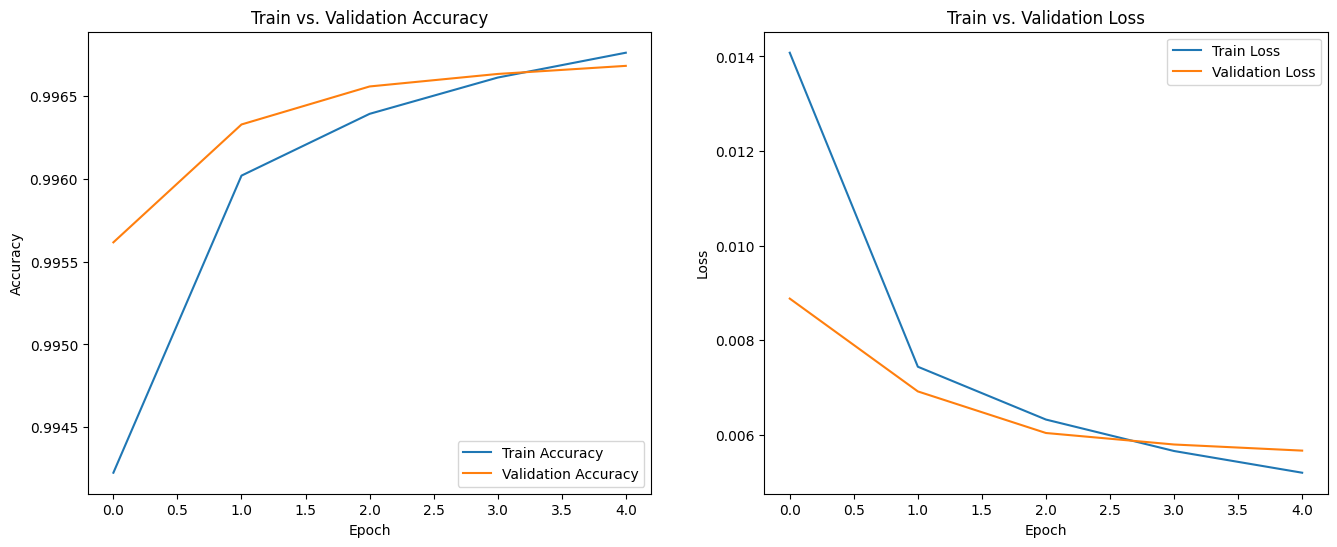

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Train vs. Validation Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend(loc='lower right')

# Plot loss
axes[1].plot(history.history['loss'], label='Train Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Train vs. Validation Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend(loc='upper right')

plt.show()

Confusion Matrix

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


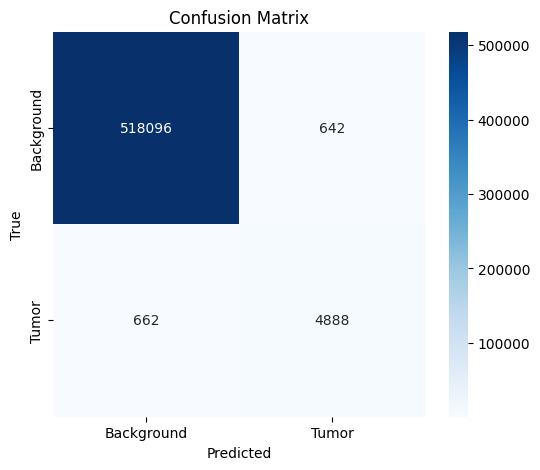

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Assume we take one batch from test_dataset for demonstration
for images, masks in test_dataset.take(1):
    preds = unet.predict(images)
    # Threshold predictions to obtain binary masks
    preds_bin = (preds > 0.5).astype(np.uint8)

    # Flatten the arrays (each pixel becomes a sample)
    y_true = masks.numpy().flatten()
    y_pred = preds_bin.flatten()

    # Ensure both y_true and y_pred are of integer type and contain only 0 and 1
    y_true = (y_true > 0.5).astype(int)  # Convert to int and threshold
    y_pred = y_pred.astype(int)         # Convert to int


    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Background", "Tumor"],
                yticklabels=["Background", "Tumor"])
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()

Visualizing Predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step


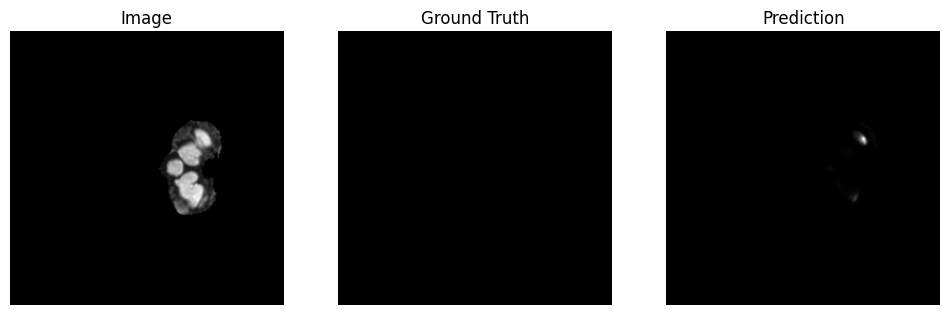

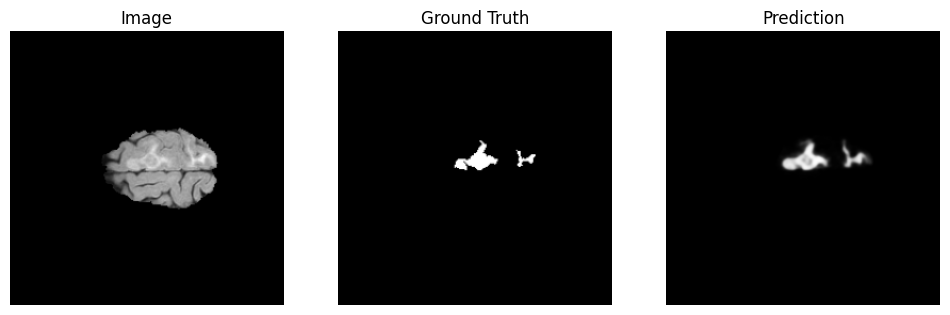

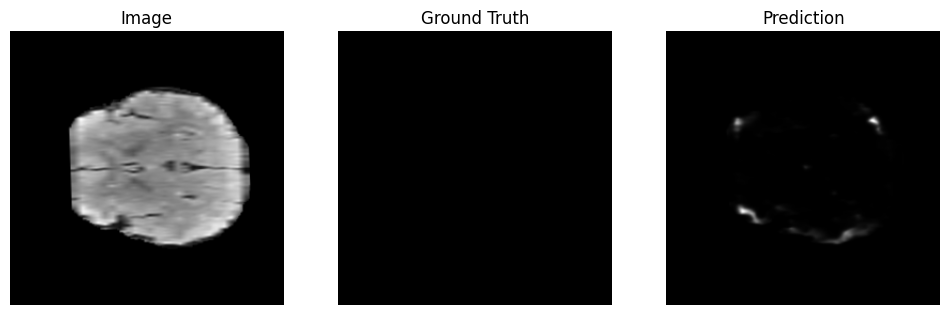

In [ ]:
def display_prediction(image, mask, prediction):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(tf.squeeze(image))
    plt.title("Image")
    plt.axis('off')

    plt.subplot(1, 3, 2)
    plt.imshow(tf.squeeze(mask), cmap='gray')
    plt.title("Ground Truth")
    plt.axis('off')

    plt.subplot(1, 3, 3)
    plt.imshow(tf.squeeze(prediction), cmap='gray')
    plt.title("Prediction")
    plt.axis('off')
    plt.show()

# Take one batch from the test dataset and display predictions
for images, masks in test_dataset.take(1):
    preds = unet.predict(images)
    for i in range(min(3, images.shape[0])):
        display_prediction(images[i], masks[i], preds[i])

Save the Model

In [ ]:
# Save the entire model as an HDF5 file in your Google Drive
model_save_path = "/content/drive/MyDrive/DSGP/U-Net.h5"
unet.save(model_save_path)
print("Model saved to:", model_save_path)

model_save_path = "/content/drive/MyDrive/DSGP/U-Net_2.keras"
unet.save(model_save_path)
print("Model saved to:", model_save_path)

Model saved to: /content/drive/MyDrive/DSGP/U-Net.h5
Model saved to: /content/drive/MyDrive/DSGP/U-Net_2.keras
